In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from vectorCorrection import vectorCorrection as vector


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
plt.rcParams.update({'font.size':22})
# from matplotlib import rc

# # activate latex text rendering
# rc('text', usetex=True)https://ood.hpc.arizona.edu/node/r6u27n1.puma.hpc.arizona.edu/31612/notebooks/pears/notebooks/pairs-z0.ipynb#

In [3]:
style = {"dark":"dashed","hydro":"solid"}
palette = { "dark":"#044751","hydro": "#B6DAFF", 
           "Illustris":"#668AFF","TNG": "#B6DAFF", # "TNG": "#7B55F3"
           "Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC",
           "All Pairs":"#668AFF","Major Pairs": "#7B55F3",
           "Minor Pairs":'#FFB201',"Minor Plus Pairs":"#FF6300",
           "Extra":"#DE2280","Stellar":"#0A68DD",
           "Halo":"#4B0094","Max Halo":"#FF6BB7"}
alphaVal = {"Major":0.7,"Minor":0.4}

In [4]:
f = h5py.File("../data/pairs/Illustris_z0-io.hdf5","r")
g = h5py.File("../data/pairs/TNG_z0-io.hdf5","r")

## Unpack values into dictionary for faster plotting!

In [5]:
Illustris, TNG = {}, {}
for key in f.keys():
    Illustris[key], TNG[key] = {}, {}
    
    if key=="Header":
        for headkey, headval in f[key].attrs.items():
            Illustris[key][headkey] = np.array(headval)
        for headkey, headval in g[key].attrs.items():
            TNG[key][headkey] = np.array(headval)
            
    
    else:
        for subkey in f[key].keys():
            Illustris[key][subkey], TNG[key][subkey] = {}, {}
            
            for subsubkey, val in f[key][subkey].items():
                Illustris[key][subkey][subsubkey] = np.array(val)
            for subsubkey, val in g[key][subkey].items():
                TNG[key][subkey][subsubkey] = np.array(val)


# Relvel vs. Sep scatter <font size=1>*takes 2 min to run*</font>

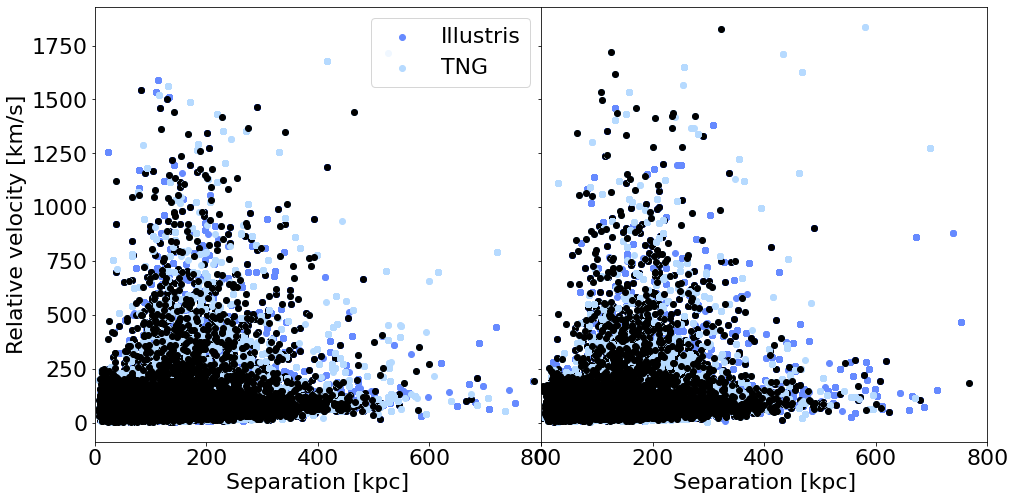

In [7]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
plt.subplots_adjust(wspace=0)



simNames = ["Illustris", "TNG"]
for ind, sim in enumerate([Illustris, TNG]):
    
    darkmask = sim['dark']['dwarf']["Realization"]==-1
    hydromask = sim['hydro']['dwarf']["Realization"]==-1
    
    darkseps = sim['dark']['dwarf']["Separation"]
    darkvels = sim['dark']['dwarf']["RelVel"]
    
    hydroseps = sim['hydro']['dwarf']["Separation"]
    hydrovels = sim['hydro']['dwarf']["RelVel"]
    
    ax[0].scatter(darkseps, darkvels,label=simNames[ind],color=palette[simNames[ind]])
    ax[1].scatter(hydroseps, hydrovels,label=simNames[ind],color=palette[simNames[ind]])
    
    ax[0].scatter(darkseps[darkmask], darkvels[darkmask],color='black')
    ax[1].scatter(hydroseps[hydromask], hydrovels[hydromask],color='black')

for i in ax:
    i.set_xlim(0,800)e
    i.set_xlabel("Separation [kpc]")
    
ax[0].legend(loc="upper right")
ax[0].set_ylabel("Relative velocity [km/s]")
ax[0].set_xlabel("Separation [kpc]")
ax[1].set_xlabel("Separation [kpc]")

plt.show()


# Exploring realizations

In [6]:
def keyplot(sim_name="Illustris", size="dwarf", key="Seperation", incl_median=True,bins=np.linspace(0,800,20),save=False):
    if sim_name=="Illustris":
        sim = Illustris
    elif sim_name=="TNG":
        sim = TNG
    else:
        print("Please enter either string 'Illustris' or 'TNG' for sim_name")
        return
    
    fig,ax = plt.subplots(2,2,figsize=(16,12),sharey='row')
    plt.subplots_adjust(wspace=0,hspace=0)
    
    for enum, phys in enumerate(["dark","hydro"]):
    
        dataset = sim[phys][size]

        prim = dataset["Stellar Mass Ratio"] < 1
        big = dataset["Stellar Mass Ratio"] > 1/4
        small = dataset["Stellar Mass Ratio"] > 1/10
        major = prim & big
        minor = prim & small & ~big 

        medianMask = dataset["Realization"] == -1
        majorMedian = major & medianMask
        minorMedian = minor & medianMask

        data_plot = dataset[key]
        
        # medians
        if incl_median:
            medianMask = dataset["Realization"] == -1
            majorMedian = major & medianMask
            minorMedian = minor & medianMask

            commonargs = {"bins":bins,
                         "color":"black",
                         "histtype":"step",
                         "linestyle":"solid",
                         "density":True,
                         "lw":1}

            ax[enum][0].hist(data_plot[majorMedian],  **commonargs)
            ax[enum][1].hist(data_plot[minorMedian], **commonargs)

        # major pairs
        ax[enum][0].hist(data_plot[major], 
                 bins=bins,
                 color=palette[f"{sim_name} {phys}"],
                 histtype="step",
                 linestyle="solid",
                 density=True,
                 lw=4)

        # minor pairs
        ax[enum][1].hist(data_plot[minor], 
                 bins=bins,
                 color=palette[f"{sim_name} {phys}"],
                 histtype="step",
                 linestyle="dashed",
                 density=True,
                 lw=4)

    ax[0][0].set_title("Major pairs")        
    ax[0][1].set_title("Minor pairs")        
    ax[0][0].set_ylabel(f"P({key})")
    ax[1][0].set_ylabel(f"P({key})")
    ax[1][0].set_xlabel(key)
    ax[1][1].set_xlabel(key)
    
    ax[0][1].plot([0,0],color=palette[f"{sim_name} dark"], linestyle="solid", lw=4, label=r"Major Pairs (dark)")
    ax[0][1].plot([0,0],color=palette[f"{sim_name} dark"], linestyle="dashed", lw=4, label=r"Minor Pairs (dark)")
    ax[0][1].plot([0,0],color="black", linestyle="solid", lw=1, label="Median")

    ax[1][1].plot([0,0],color=palette[f"{sim_name} hydro"], linestyle="solid", lw=4, label=r"Major Pairs (hydro)")
    ax[1][1].plot([0,0],color=palette[f"{sim_name} hydro"], linestyle="dashed", lw=4, label=r"Minor Pairs (hydro)")
    ax[1][1].plot([0,0],color="black", linestyle="solid", lw=1, label="Median")
    ax[0][1].legend()
    ax[1][1].legend()
                    
    fig.suptitle(f"{size.capitalize()} pairs - {sim_name}")

    if save:
        plt.savefig(f"../plots/pairs-z0/{key}_{sim_name}_{size}.pdf")

        
    plt.show()


# Distribution plots

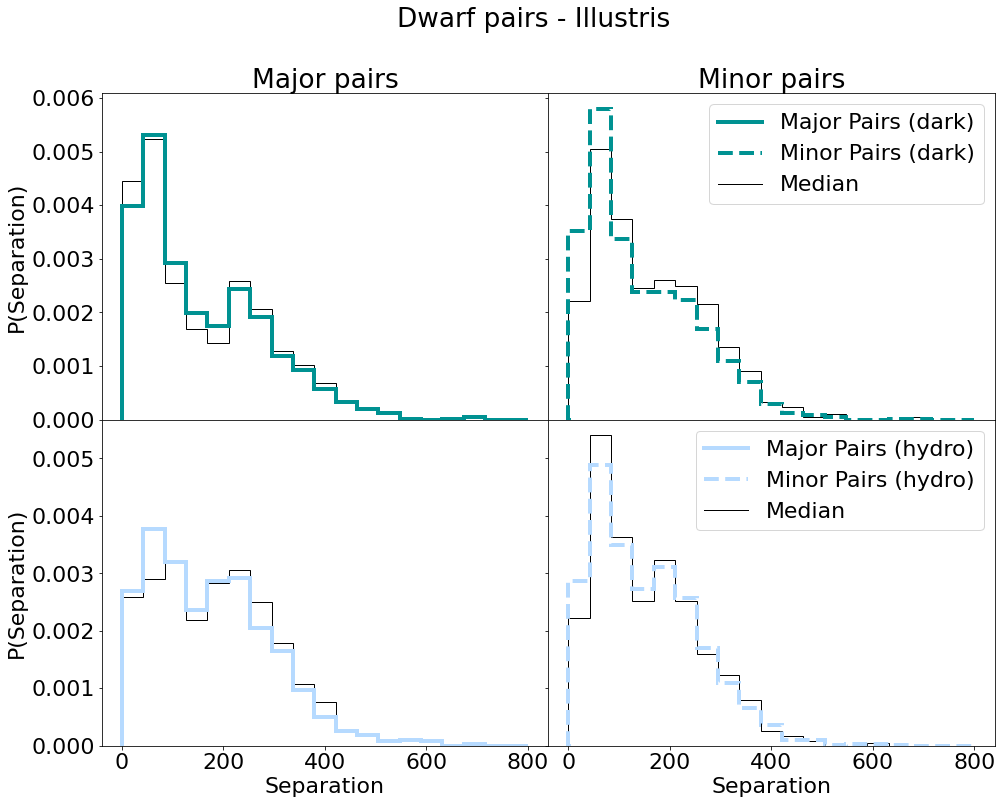

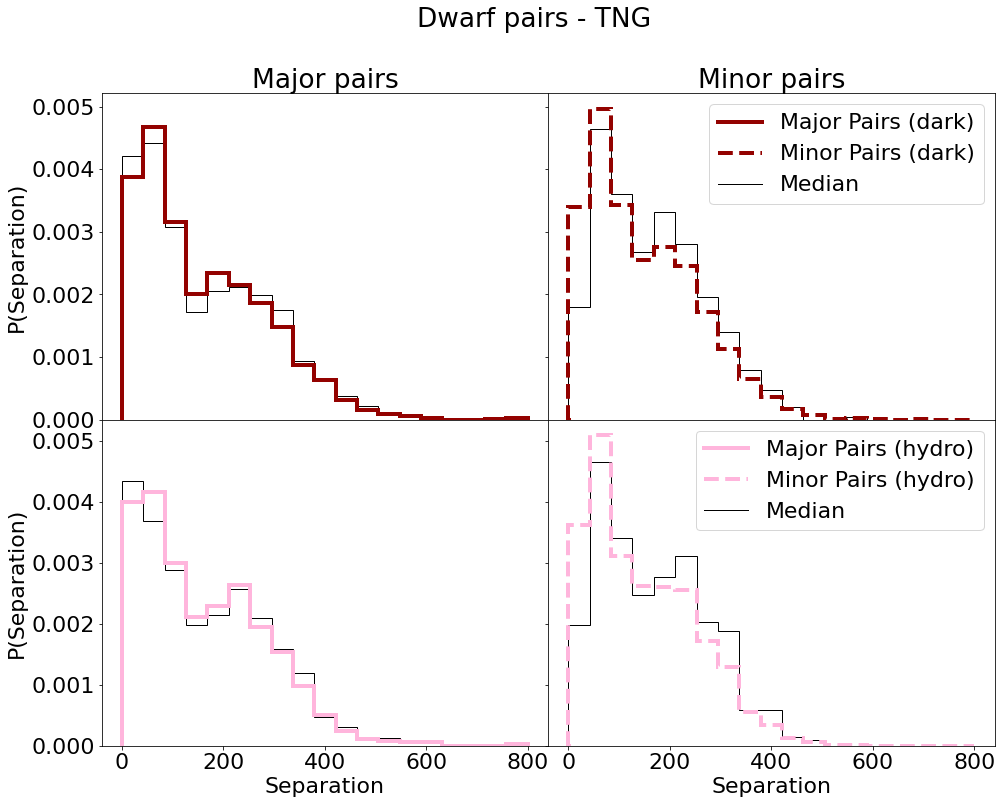

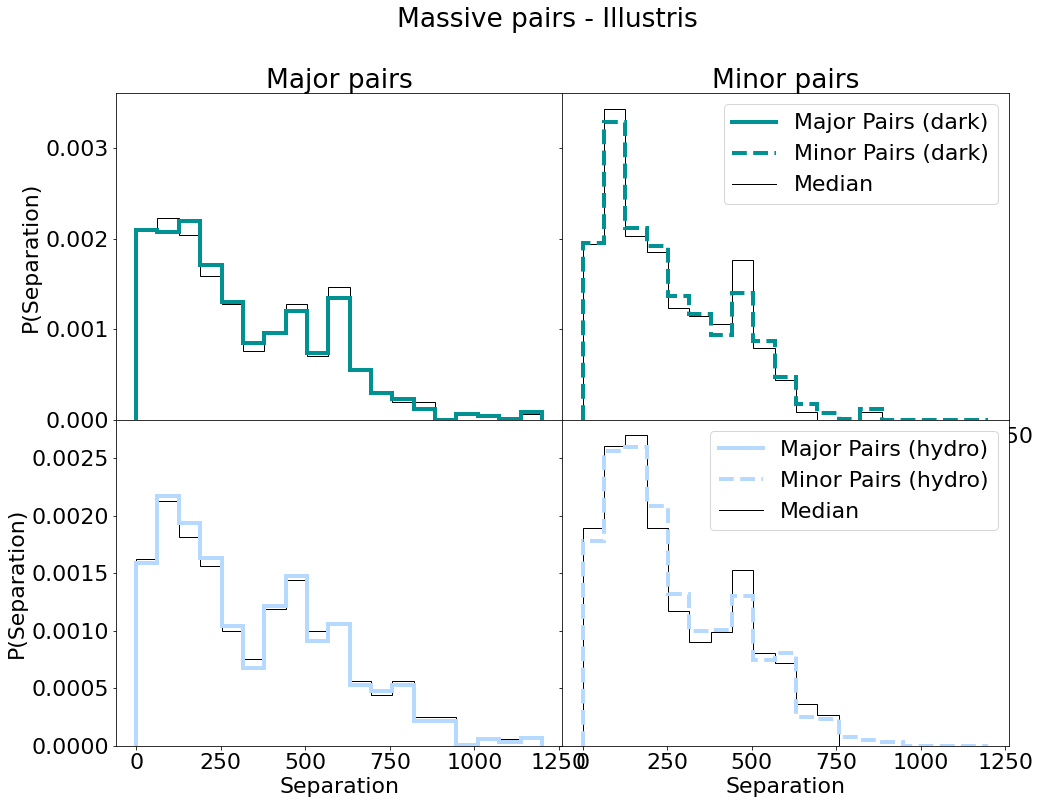

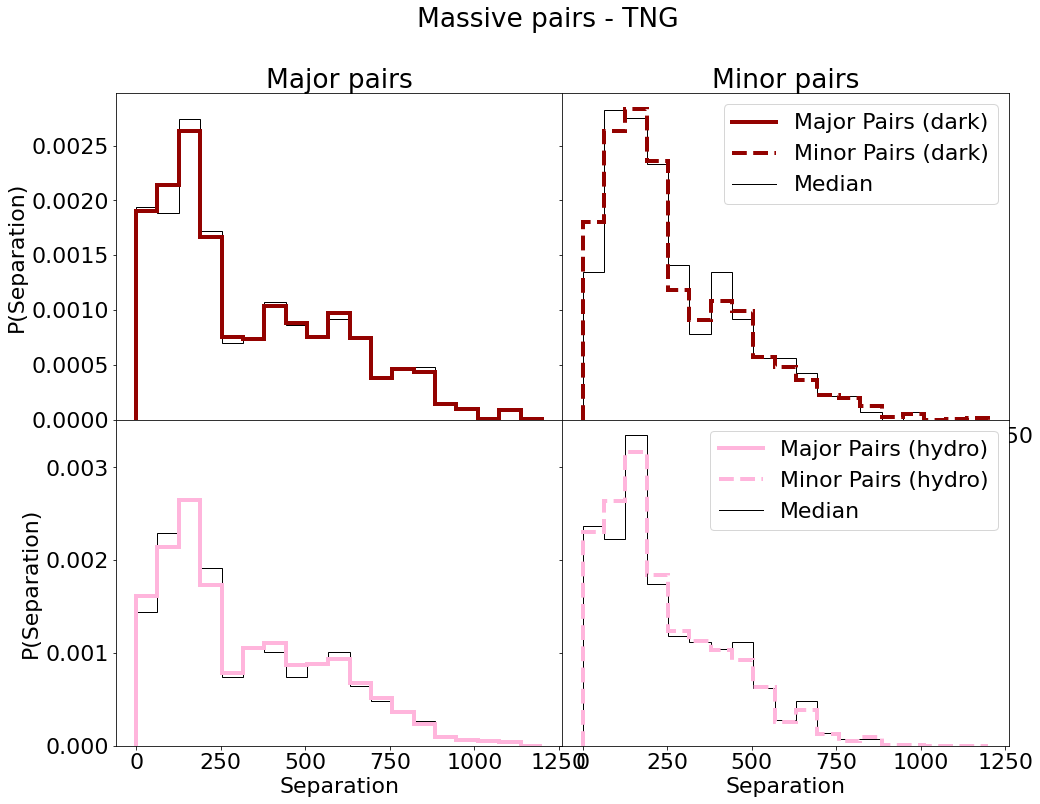

In [26]:
key = "Separation"
save = True
keyplot(sim_name="Illustris",size="dwarf",key=key,save=save)
keyplot(sim_name="TNG",size="dwarf",key=key,save=save)

massive_bins = np.linspace(0,1200,20)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins,save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins,save=save)

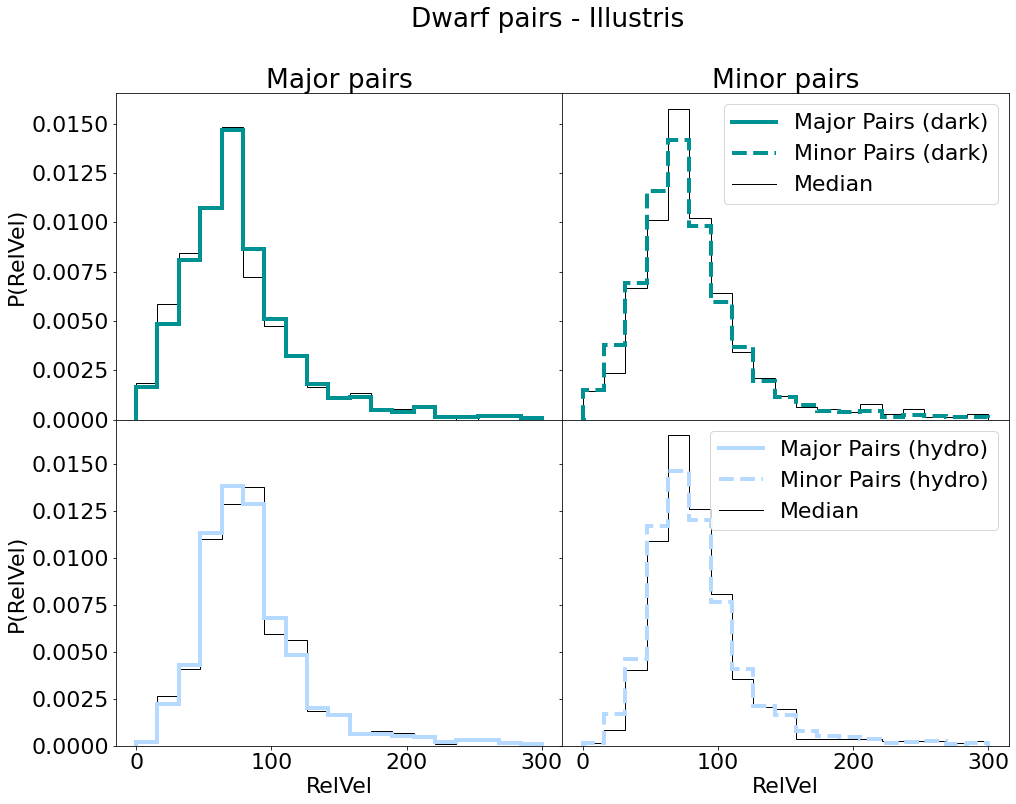

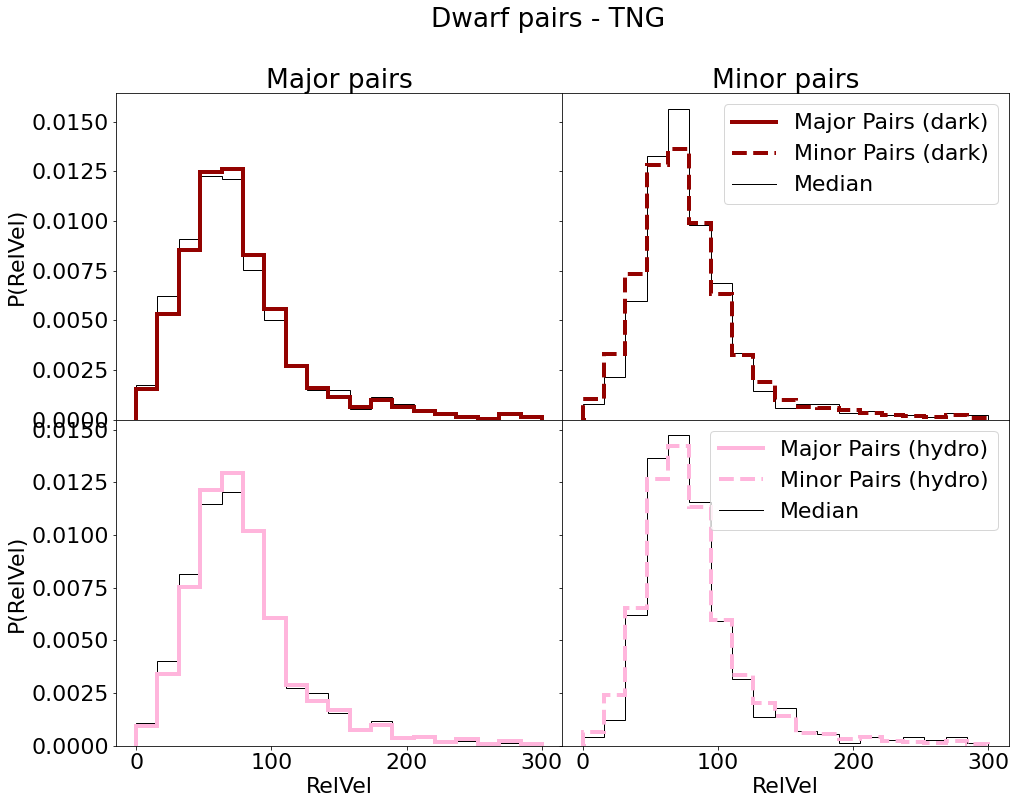

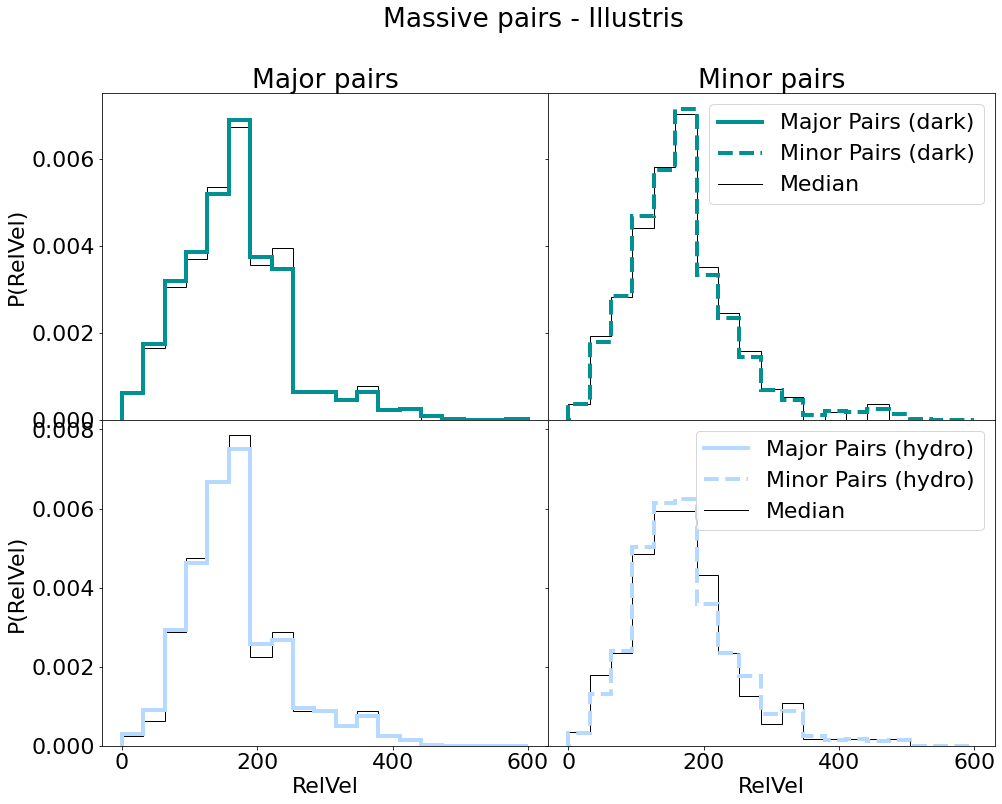

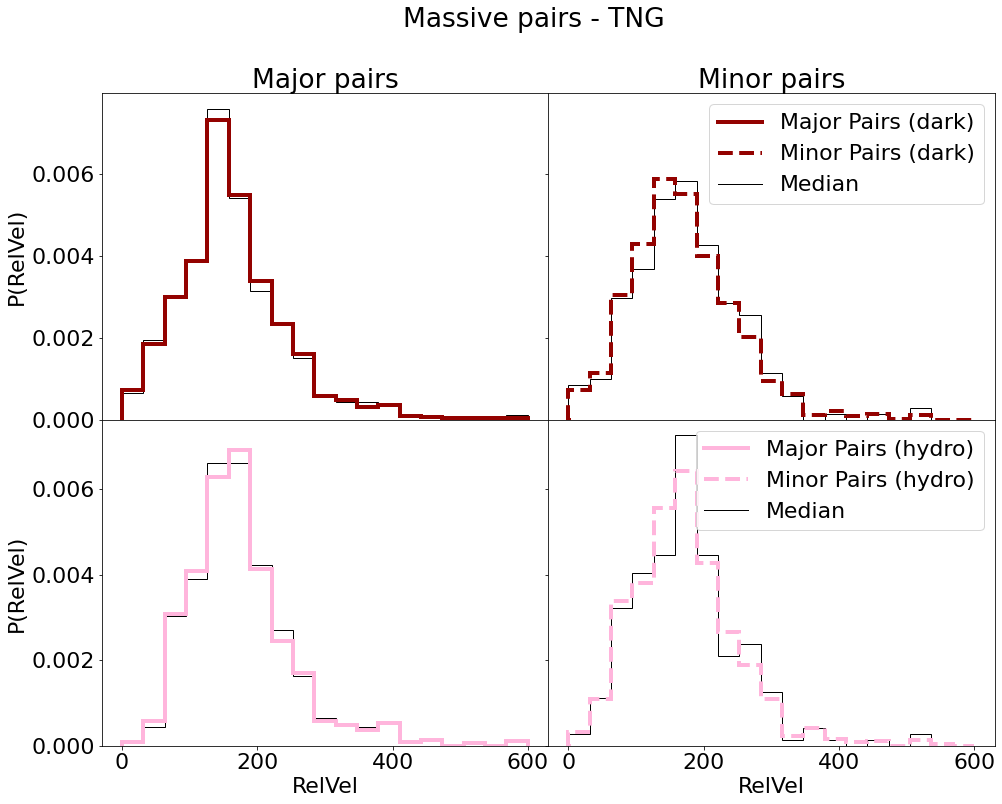

In [27]:
key = "RelVel"
save = True
dwarf_bins = np.linspace(0,300,20)
keyplot(sim_name="Illustris",size="dwarf",key=key, bins=dwarf_bins, save=save)
keyplot(sim_name="TNG",size="dwarf",key=key, bins=dwarf_bins, save=save)

massive_bins = np.linspace(0,600,20)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins, save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins, save=save)

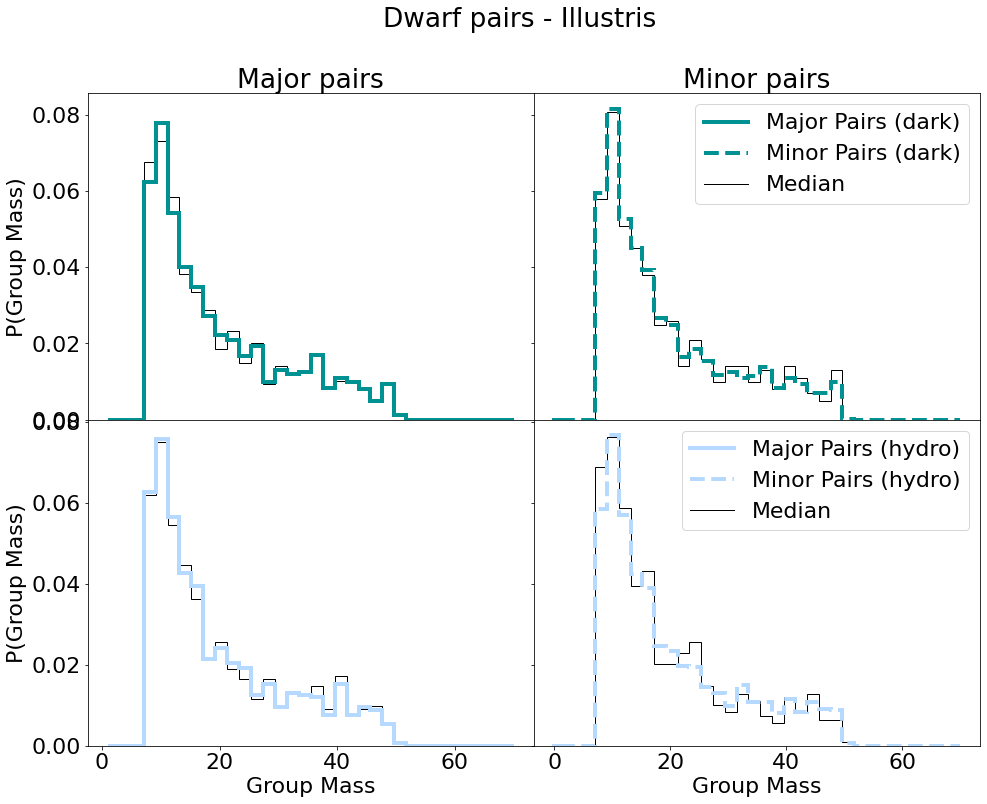

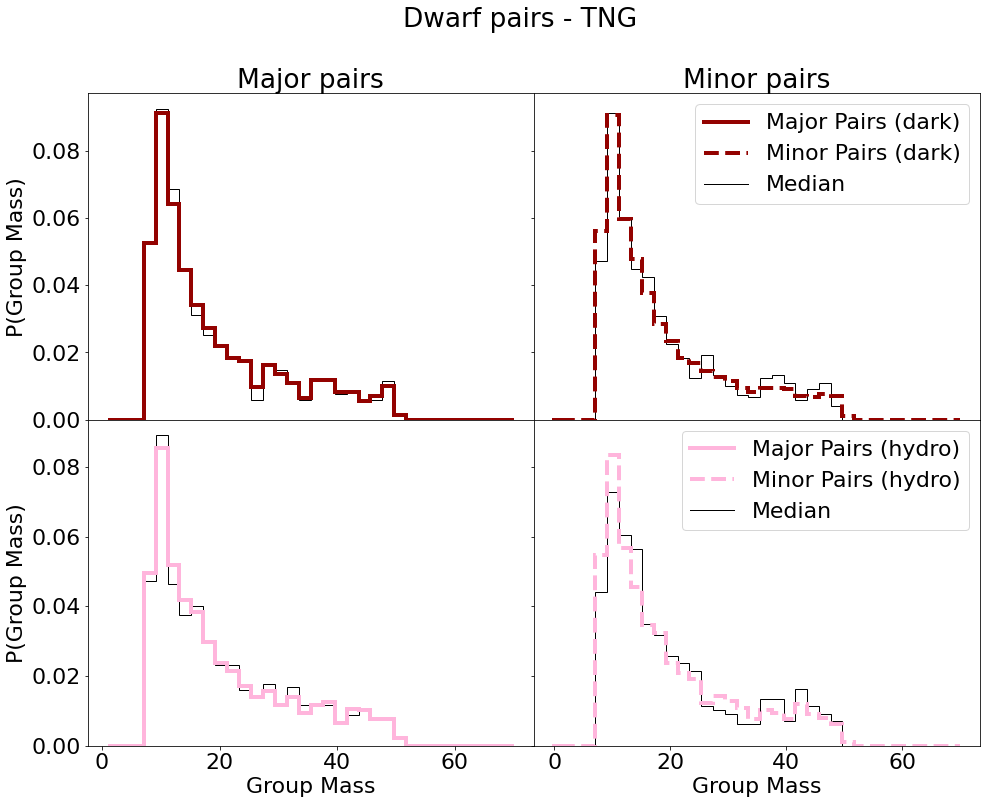

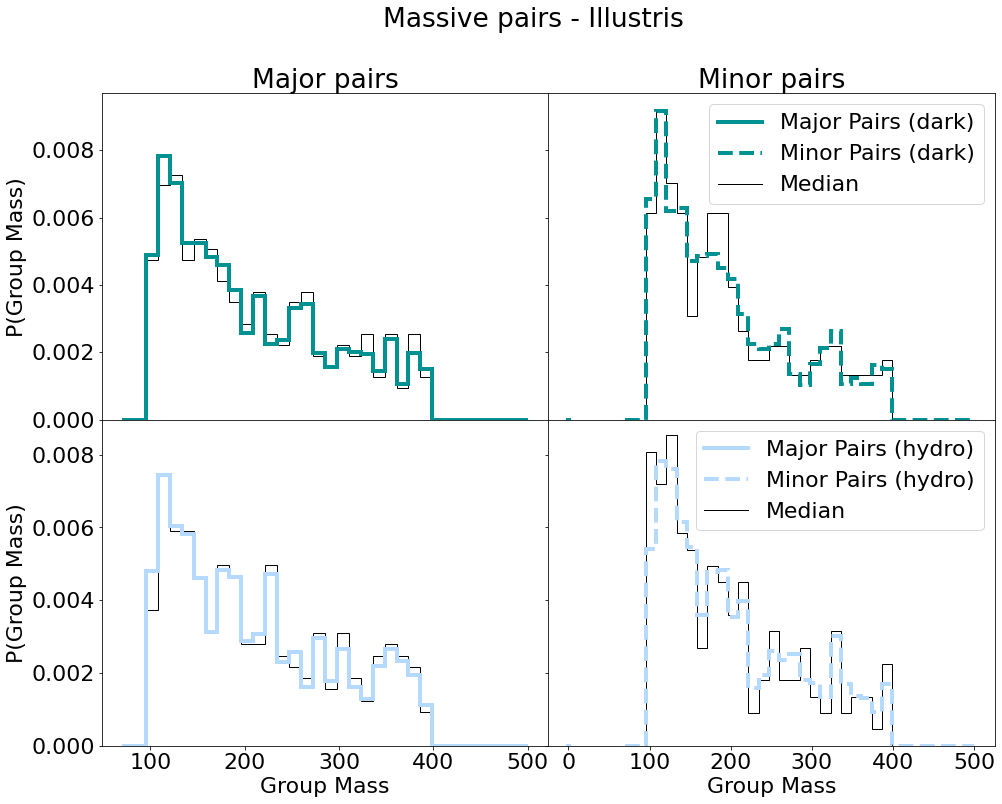

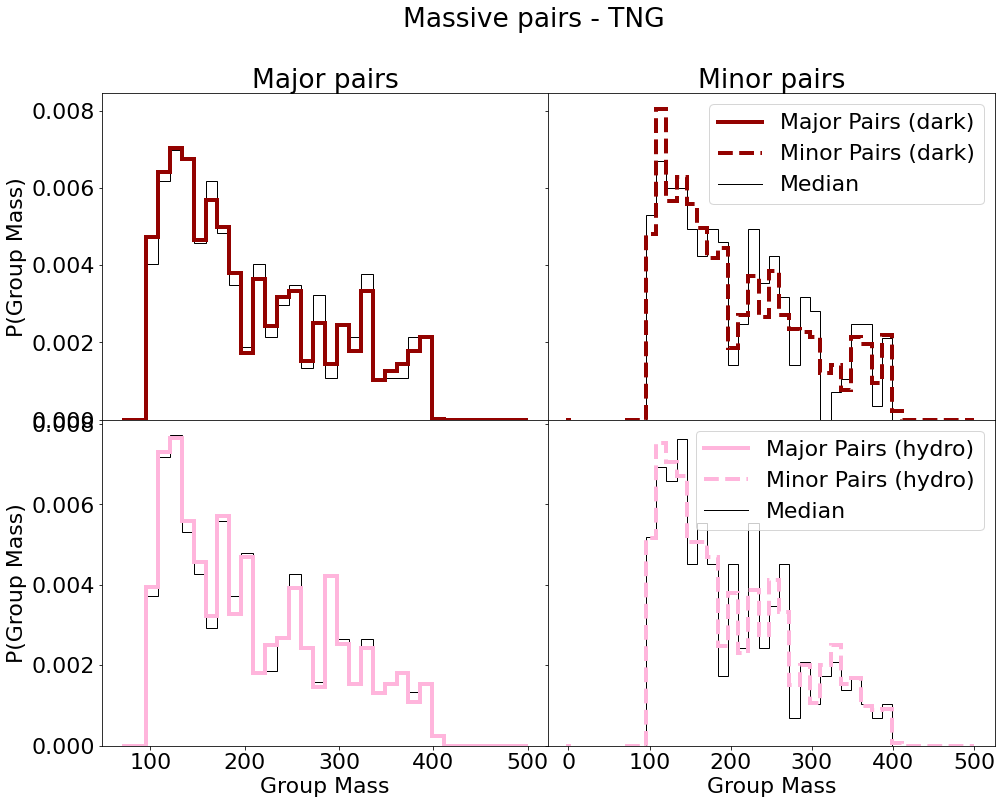

In [28]:
key = "Group Mass"
save = True
dwarf_bins = np.linspace(1,70,35)
keyplot(sim_name="Illustris",size="dwarf",key=key, bins=dwarf_bins, save=save)
keyplot(sim_name="TNG",size="dwarf",key=key, bins=dwarf_bins, save=save)

massive_bins = np.linspace(70,500,35)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins, save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins, save=save)

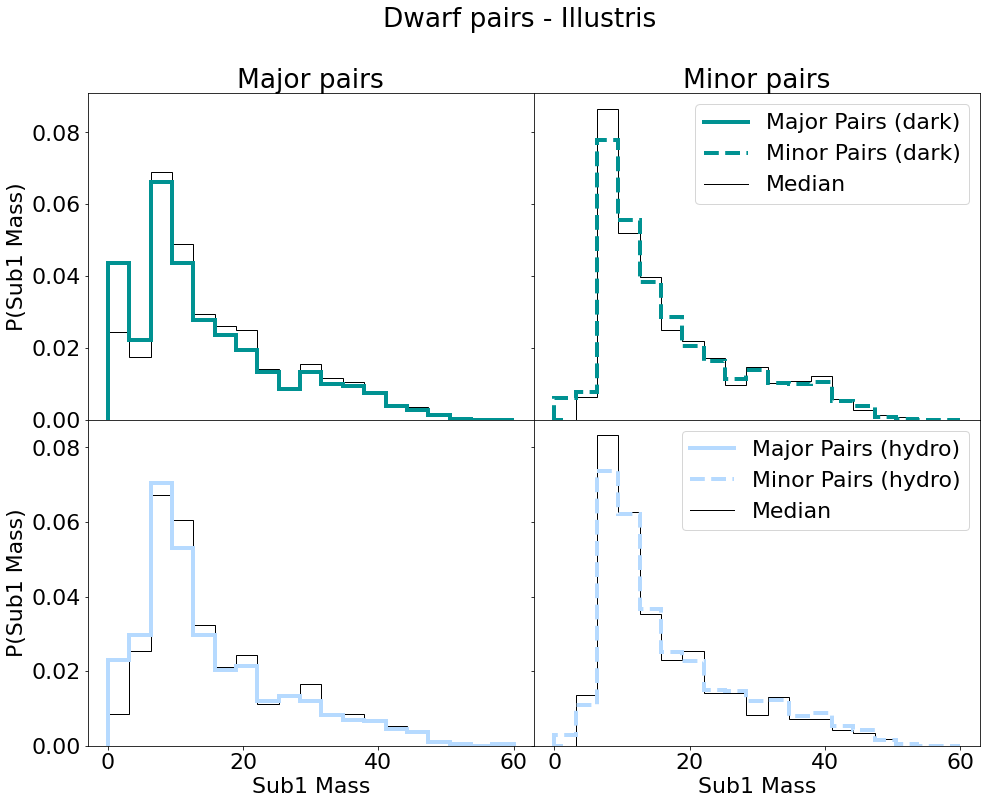

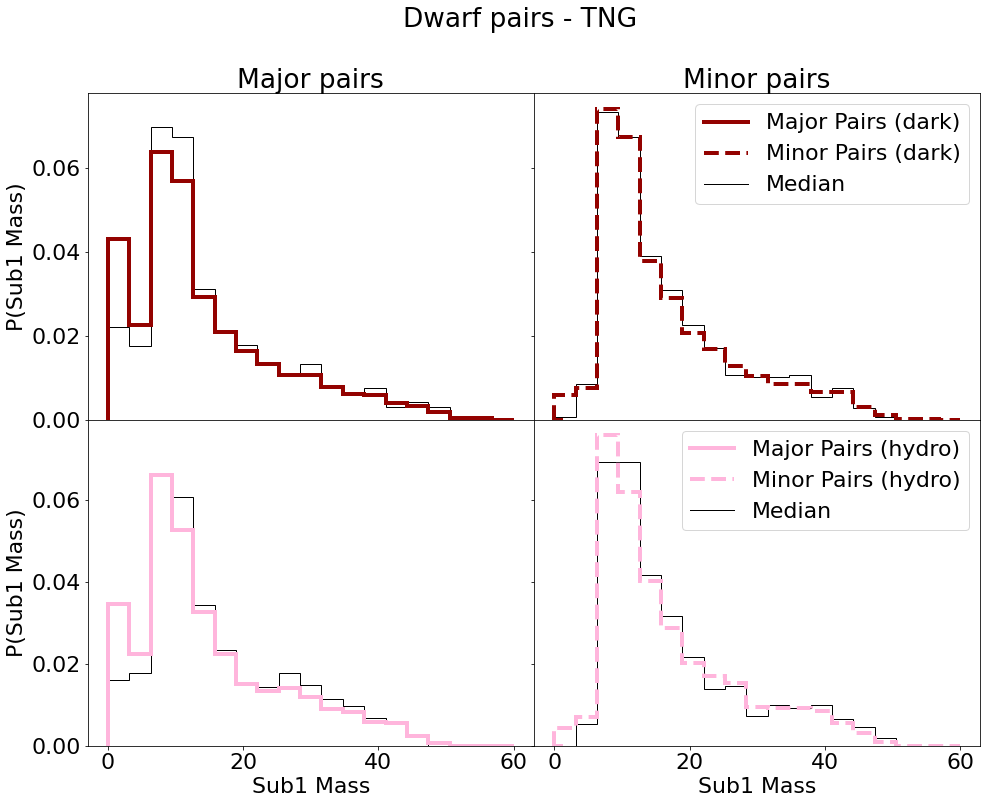

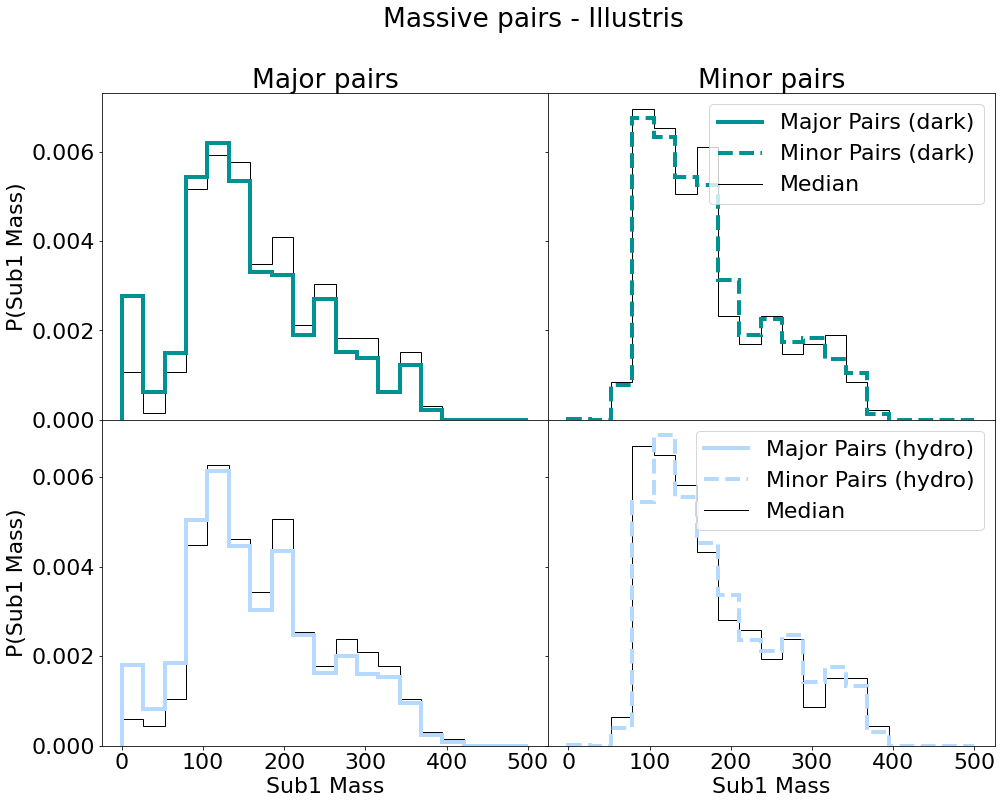

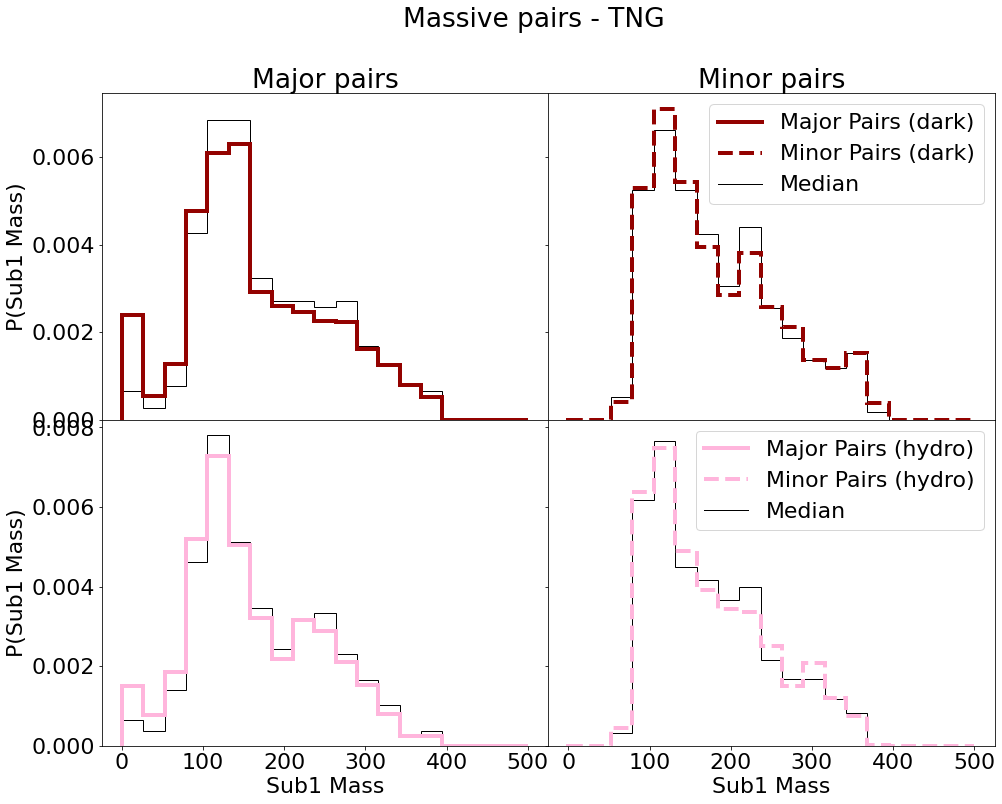

In [29]:
key = "Sub1 Mass"
save = True
dwarf_bins = np.linspace(0,60,20)
keyplot(sim_name="Illustris",size="dwarf",key=key, bins=dwarf_bins, save=save)
keyplot(sim_name="TNG",size="dwarf",key=key, bins=dwarf_bins, save=save)

massive_bins = np.linspace(0,500,20)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins, save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins, save=save)

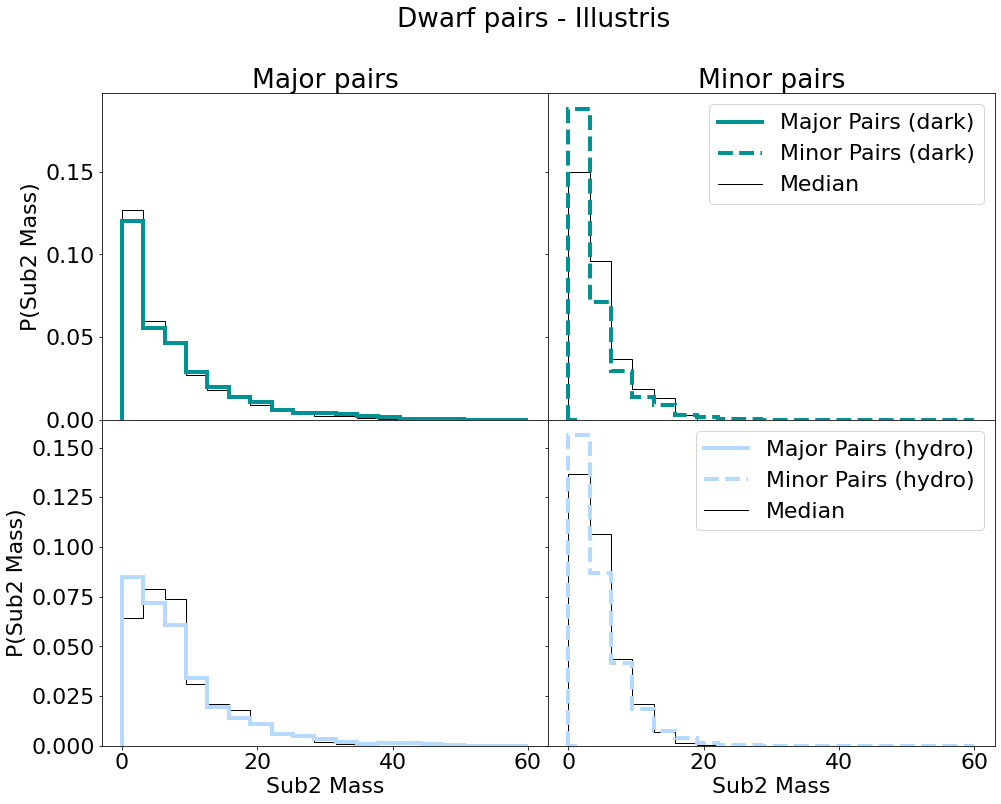

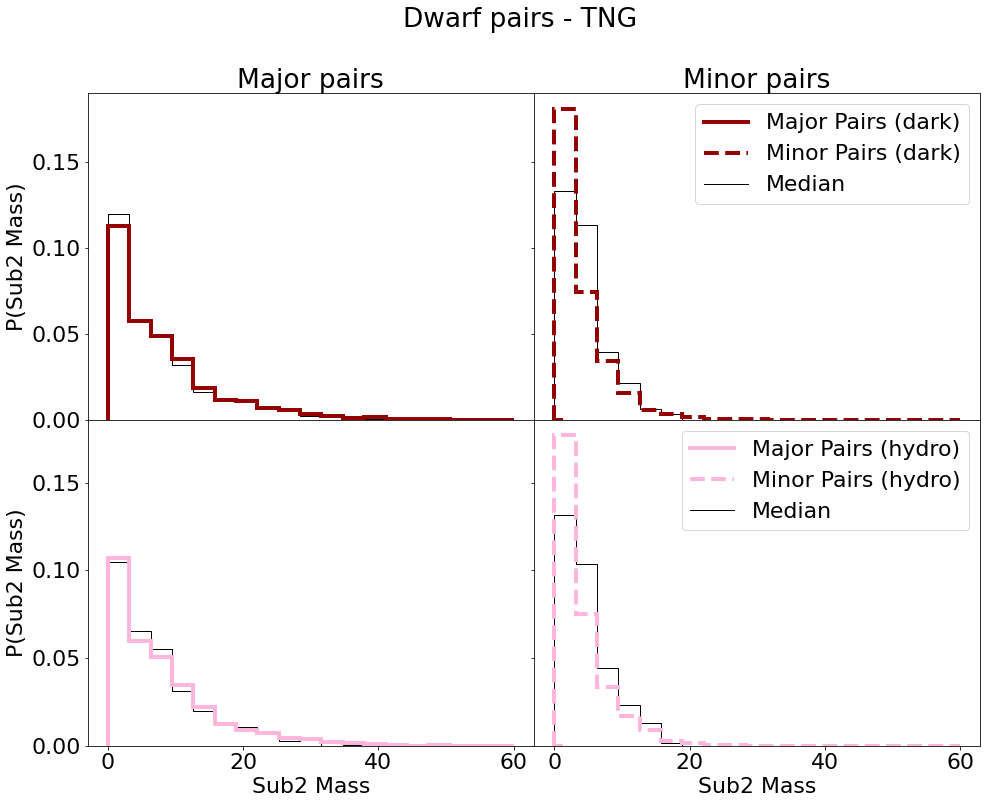

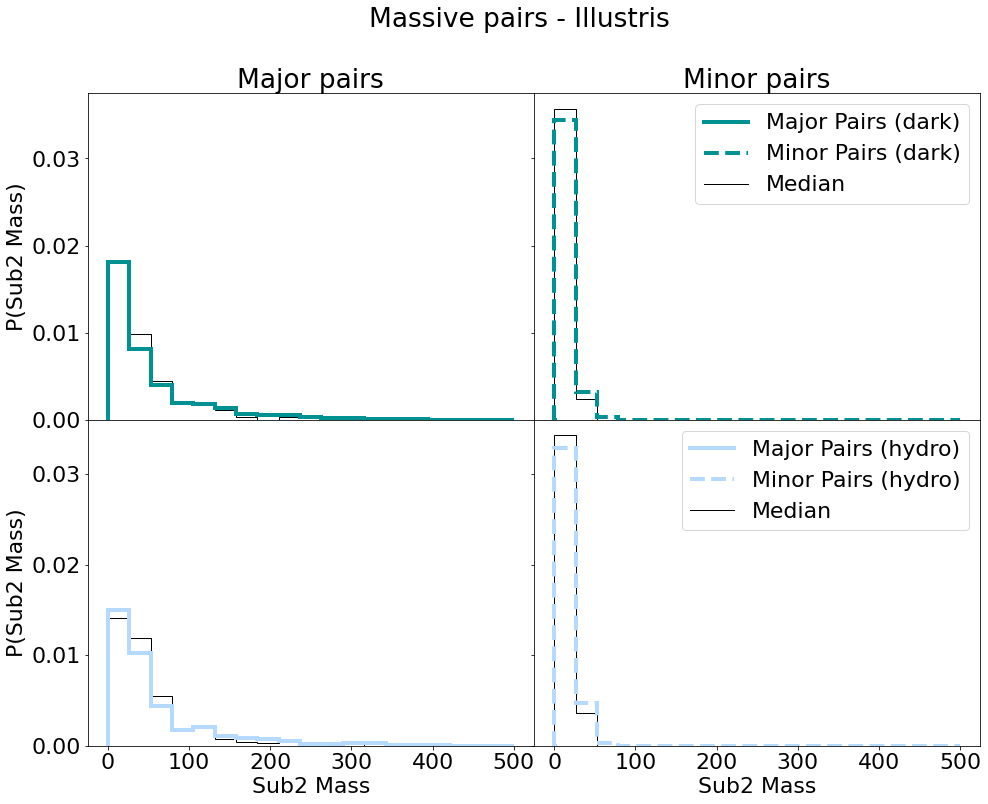

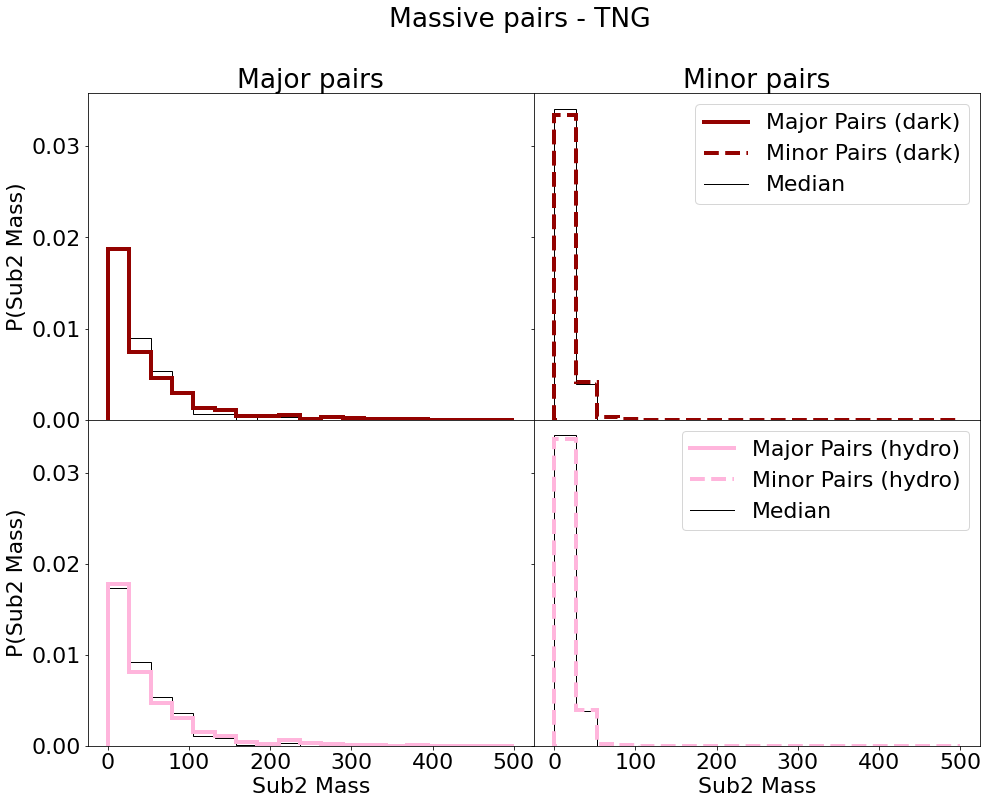

In [30]:
key = "Sub2 Mass"
save = True
dwarf_bins = np.linspace(0,60,20)
keyplot(sim_name="Illustris",size="dwarf",key=key, bins=dwarf_bins, save=save)
keyplot(sim_name="TNG",size="dwarf",key=key, bins=dwarf_bins, save=save)

massive_bins = np.linspace(0,500,20)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins, save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins, save=save)

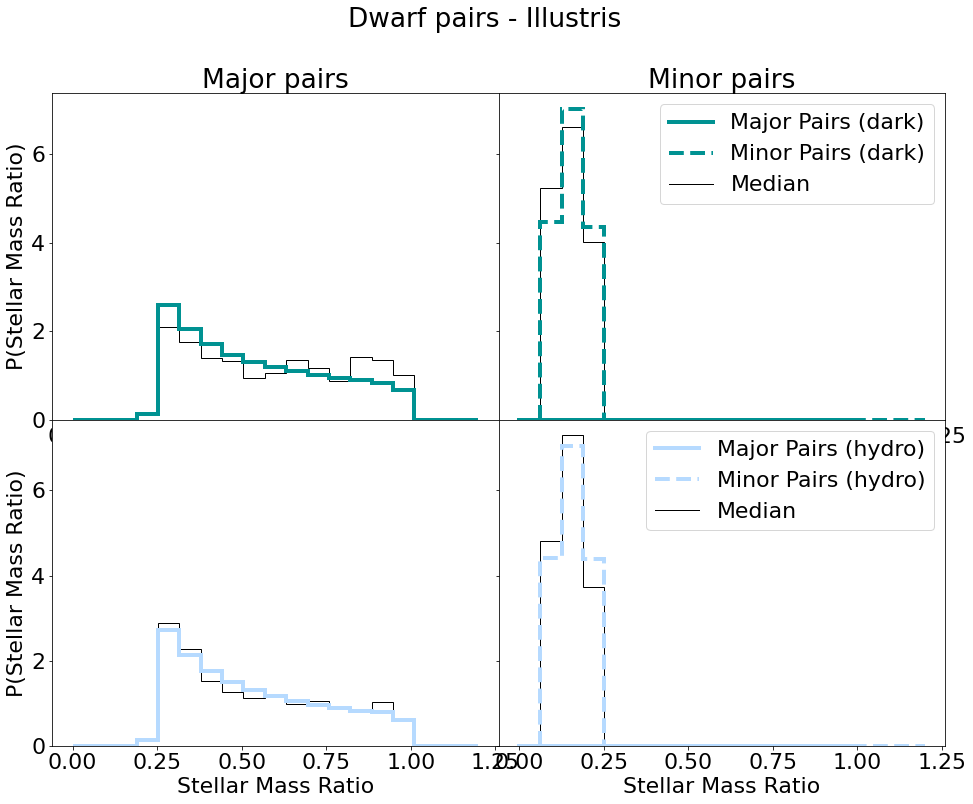

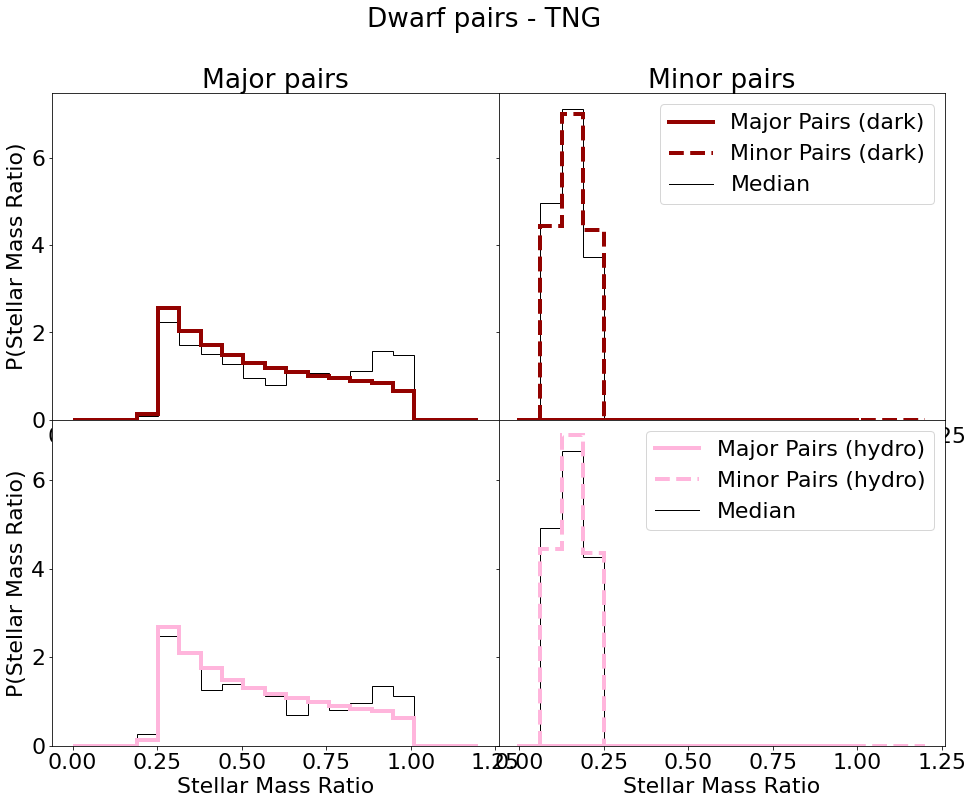

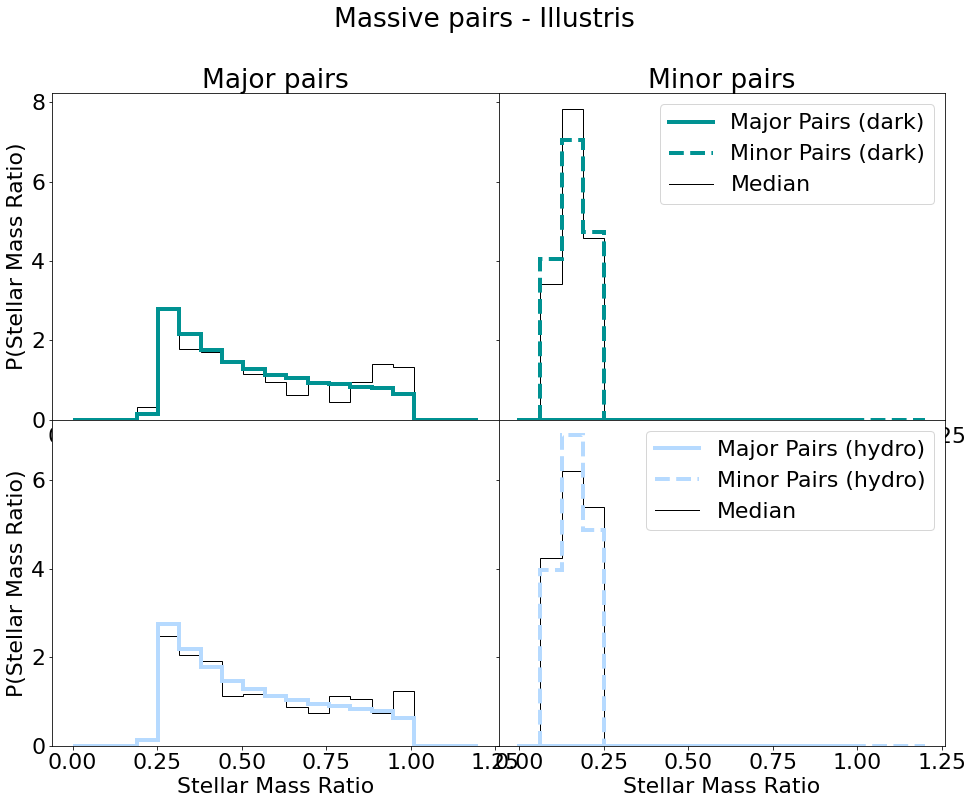

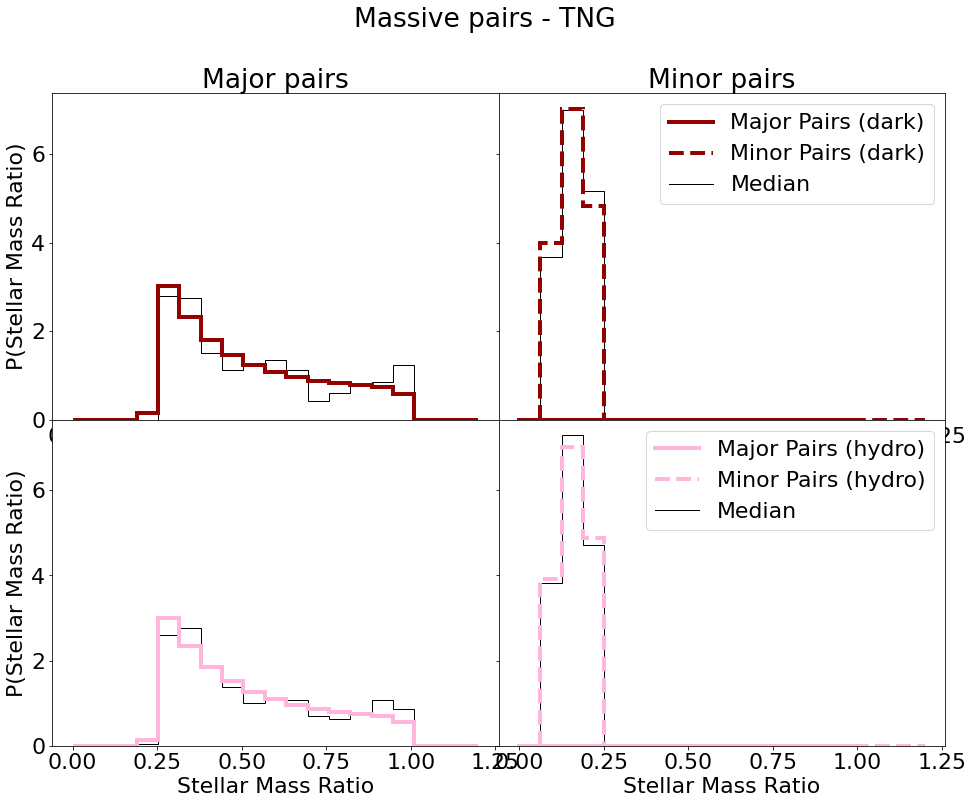

In [45]:
key = "Stellar Mass Ratio"
save = True
dwarf_bins = np.linspace(0,1.2,20)
keyplot(sim_name="Illustris",size="dwarf",key=key, bins=dwarf_bins, save=save)
keyplot(sim_name="TNG",size="dwarf",key=key, bins=dwarf_bins, save=save)

massive_bins = np.linspace(0,1.2,20)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins, save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins, save=save)

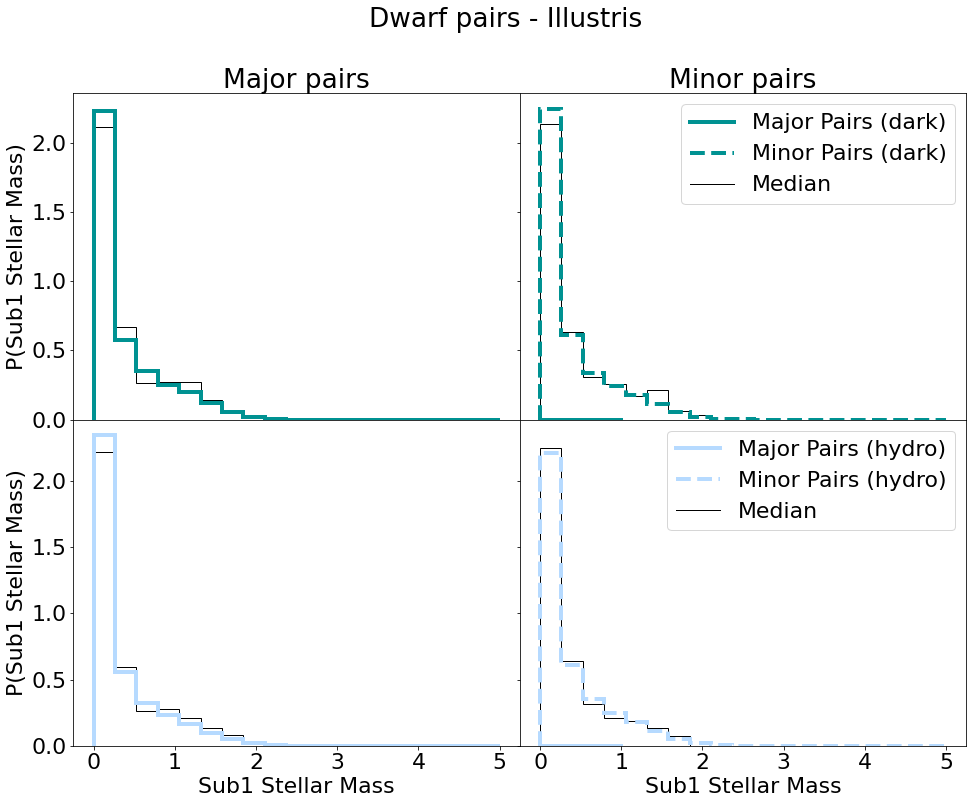

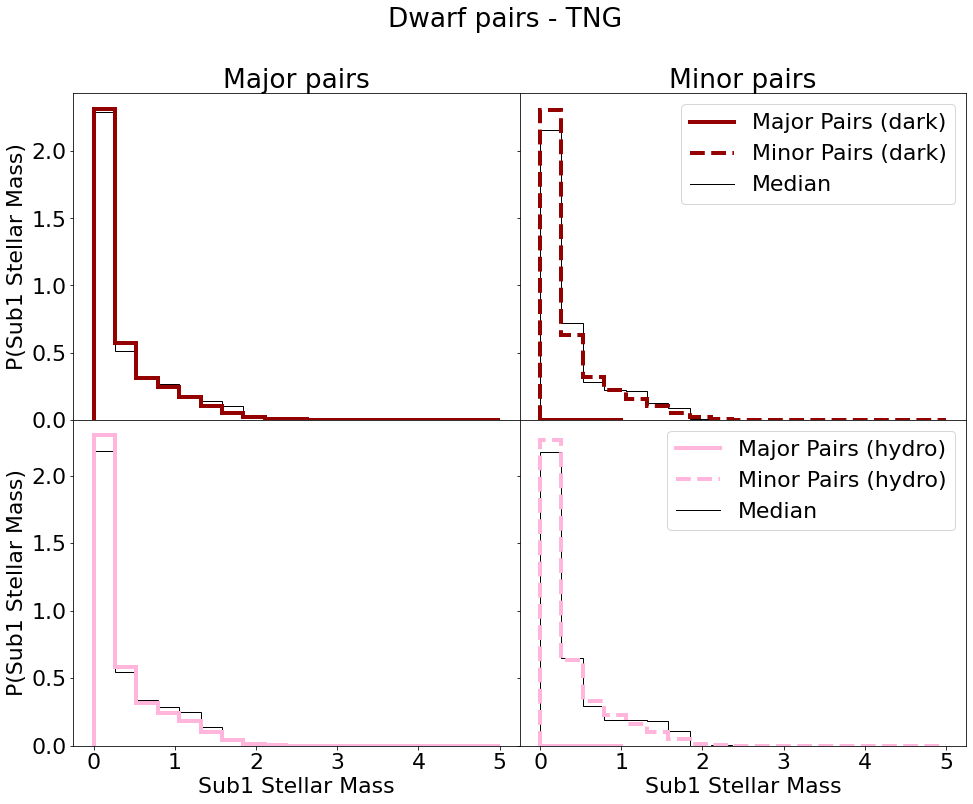

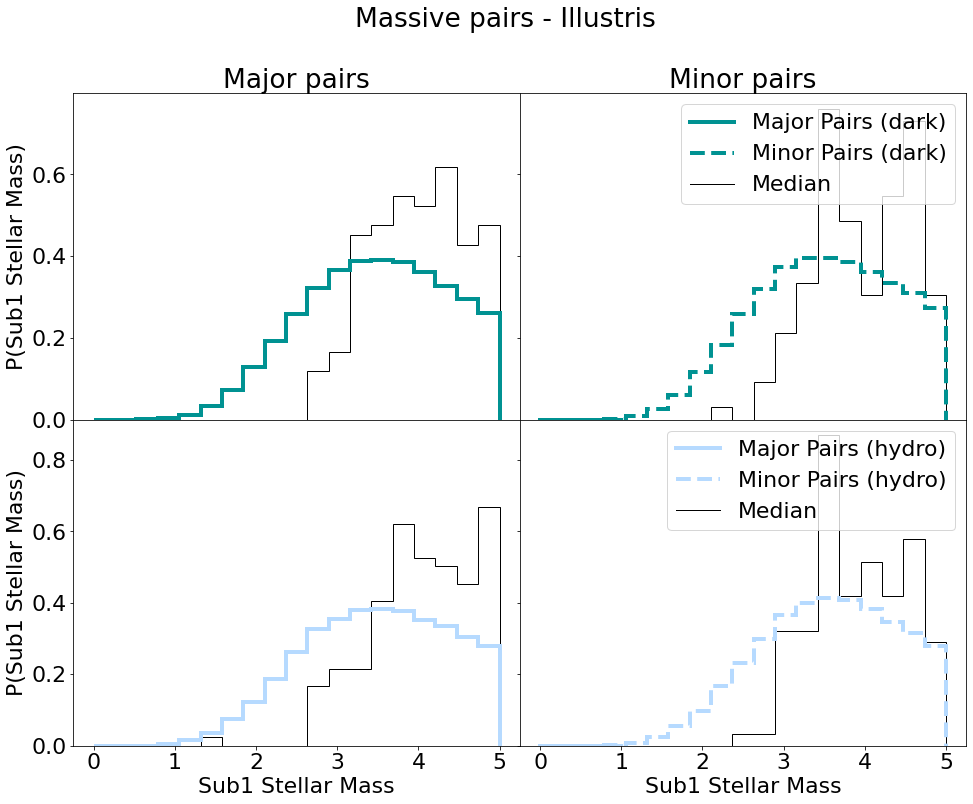

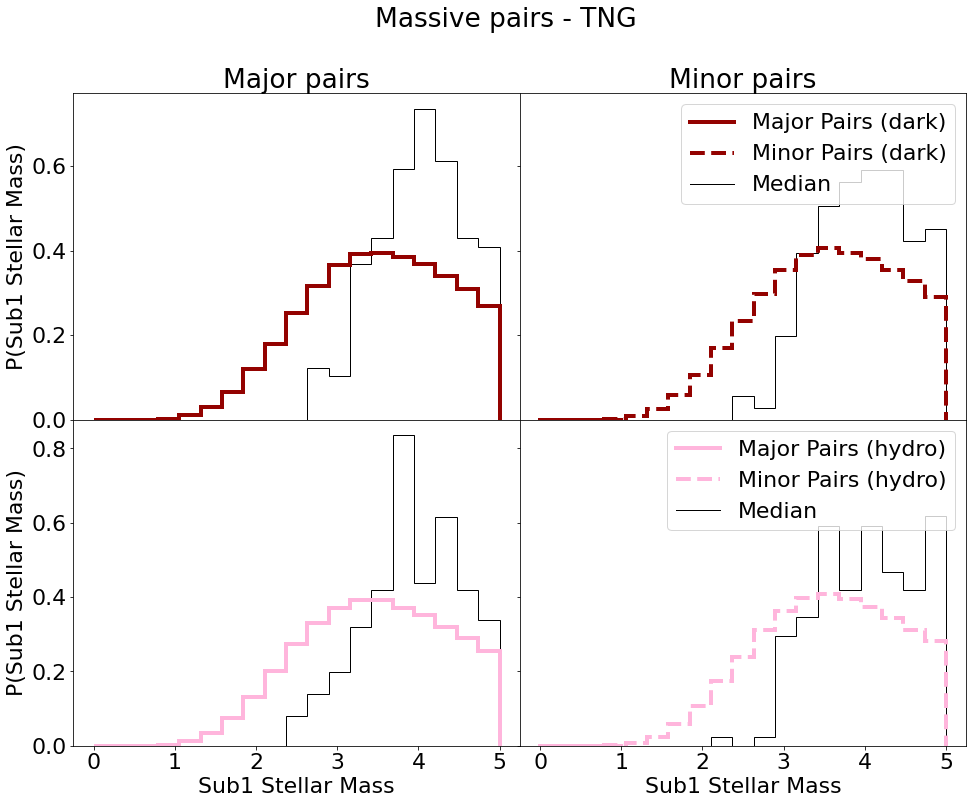

In [8]:
key = "Sub1 Stellar Mass"
save = False
dwarf_bins = np.linspace(0,5,20)
keyplot(sim_name="Illustris",size="dwarf",key=key, bins=dwarf_bins, save=save)
keyplot(sim_name="TNG",size="dwarf",key=key, bins=dwarf_bins, save=save)

massive_bins = np.linspace(0,5,20)
keyplot(sim_name="Illustris",size="massive",key=key,bins=massive_bins, save=save)
keyplot(sim_name="TNG",size="massive",key=key,bins=massive_bins, save=save)

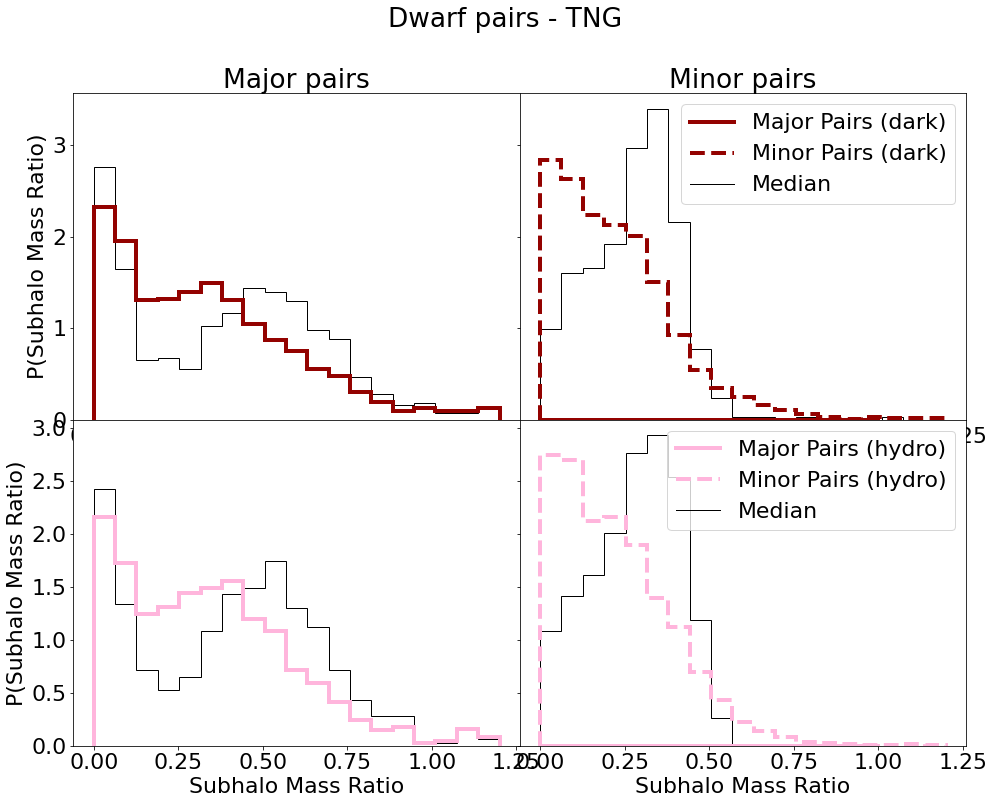

In [44]:
sim_name="TNG"
sim=TNG
key="Subhalo Mass Ratio"
size="dwarf"
incl_median=True
bins = np.linspace(0,1.2,20)

fig,ax = plt.subplots(2,2,figsize=(16,12),sharey='row')
plt.subplots_adjust(wspace=0,hspace=0)

for enum, phys in enumerate(["dark","hydro"]):

    dataset = sim[phys][size]

    prim = dataset["Stellar Mass Ratio"] < 1
    big = dataset["Stellar Mass Ratio"] > 1/4
    small = dataset["Stellar Mass Ratio"] > 1/10
    major = prim & big
    minor = prim & small & ~big 

    medianMask = dataset["Realization"] == -1
    majorMedian = major & medianMask
    minorMedian = minor & medianMask

    data_plot = dataset["Sub2 Mass"]/dataset["Sub1 Mass"]

    # medians
    if incl_median:
        medianMask = dataset["Realization"] == -1
        majorMedian = major & medianMask
        minorMedian = minor & medianMask

        commonargs = {"bins":bins,
                     "color":"black",
                     "histtype":"step",
                     "linestyle":"solid",
                     "density":True,
                     "lw":1}

        ax[enum][0].hist(data_plot[majorMedian],  **commonargs)
        ax[enum][1].hist(data_plot[minorMedian], **commonargs)

    # major pairs
    ax[enum][0].hist(data_plot[major], 
             bins=bins,
             color=palette[f"{sim_name} {phys}"],
             histtype="step",
             linestyle="solid",
             density=True,
             lw=4)

    # minor pairs
    ax[enum][1].hist(data_plot[minor], 
             bins=bins,
             color=palette[f"{sim_name} {phys}"],
             histtype="step",
             linestyle="dashed",
             density=True,
             lw=4)

ax[0][0].set_title("Major pairs")        
ax[0][1].set_title("Minor pairs")        
ax[0][0].set_ylabel(f"P({key})")
ax[1][0].set_ylabel(f"P({key})")
ax[1][0].set_xlabel(key)
ax[1][1].set_xlabel(key)

ax[0][1].plot([0,0],color=palette[f"{sim_name} dark"], linestyle="solid", lw=4, label=r"Major Pairs (dark)")
ax[0][1].plot([0,0],color=palette[f"{sim_name} dark"], linestyle="dashed", lw=4, label=r"Minor Pairs (dark)")
ax[0][1].plot([0,0],color="black", linestyle="solid", lw=1, label="Median")

ax[1][1].plot([0,0],color=palette[f"{sim_name} hydro"], linestyle="solid", lw=4, label=r"Major Pairs (hydro)")
ax[1][1].plot([0,0],color=palette[f"{sim_name} hydro"], linestyle="dashed", lw=4, label=r"Minor Pairs (hydro)")
ax[1][1].plot([0,0],color="black", linestyle="solid", lw=1, label="Median")
ax[0][1].legend()
ax[1][1].legend()

fig.suptitle(f"{size.capitalize()} pairs - {sim_name}")

plt.savefig(f"../plots/pairs-z0/{key}_{sim_name}_{size}.pdf")


plt.show()



# graveyard

## testing to see why my groups have more massive subhalos

In [5]:
from utils.read_group_cats import ReadCats


imported h5py...
modules seem to have loaded?


In [49]:
f["dark"]["dwarf"].keys()

<KeysViewHDF5 ['Group ID', 'Group Mass', 'Group Nsubs', 'Group Radius', 'Realization', 'RelVel', 'Separation', 'Stellar Mass Ratio', 'Sub1 ID', 'Sub1 Mass', 'Sub1 Pos', 'Sub1 Stellar Mass', 'Sub1 Vel', 'Sub2 ID', 'Sub2 Mass', 'Sub2 Pos', 'Sub2 Stellar Mass', 'Sub2 Vel']>

273146

In [6]:
sub=np.array(f["dark"]["dwarf"]["Sub1 Mass"])
grp = np.array(f["dark"]["dwarf"]["Group Mass"])

num = np.sum(grp-sub<0)
print(num/len(grp))

0.04516606108148133


In [65]:
firstLoc = np.where(grp-sub<0)


In [76]:
len(np.unique(f['dark']['dwarf']['Group ID']))

12047

In [ ]:
f['dark']['dwarf']['Group ID'][firstLoc]

In [71]:
truenum = np.unique(f['dark']['dwarf']['Group ID'][firstLoc])

In [72]:
truenum

array([ 2182,  2210,  2296,  2393,  2416,  2455,  2597,  2706,  2794,
        2814,  2825,  2862,  2864,  2909,  2935,  2937,  2944,  2970,
        3001,  3006,  3012,  3020,  3053,  3087,  3099,  3102,  3289,
        3313,  3345,  3359,  3431,  3453,  3477,  3480,  3487,  3502,
        3513,  3567,  3635,  3648,  3655,  3681,  3683,  3728,  3731,
        3735,  3746,  3773,  3779,  3783,  3840,  3926,  3936,  3944,
        3954,  3982,  3985,  4001,  4010,  4016,  4030,  4048,  4085,
        4089,  4097,  4131,  4165,  4203,  4212,  4219,  4255,  4307,
        4335,  4338,  4351,  4364,  4397,  4469,  4481,  4483,  4574,
        4579,  4616,  4626,  4648,  4702,  4713,  4715,  4717,  4730,
        4754,  4761,  4794,  4800,  4833,  4889,  4890,  4899,  4902,
        4926,  4965,  4981,  5031,  5078,  5141,  5197,  5205,  5221,
        5224,  5294,  5359,  5362,  5363,  5375,  5421,  5464,  5479,
        5497,  5501,  5551,  5580,  5608,  5614,  5627,  5669,  5673,
        5779,  5827,

In [77]:
len(truenum)/12047

0.046567610193409145

In [ ]:
f['dark']['dwarf']['Group'][firstLoc]

In [43]:
f["dark"]["dwarf"]["Group Mass"][firstLoc]

45.50384391437878

In [44]:
f["dark"]["dwarf"]["Sub1 Mass"][firstLoc]

47.98645864833485

In [46]:
f['dark']['dwarf']['Group ID'][firstLoc]

2182

In [45]:
f['dark']['dwarf']['Group Nsubs'][firstLoc]

14

In [52]:
subID = f['dark']['dwarf']['Sub1 ID'][firstLoc]

In [22]:
inst = ReadCats(snapshot=135, sim="Illustris",physics="dark")
h=0.704

In [31]:
dir(inst)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'catalog',
 'catpath',
 'groupPos',
 'inds',
 'mvirs',
 'nsubs',
 'path_am_mass',
 'path_basedir',
 'path_data',
 'path_groups',
 'path_home',
 'path_illustris',
 'path_illustrisdark',
 'path_illustrisdark_trees',
 'path_illustrishydro',
 'path_illustrishydro_trees',
 'path_illustristng',
 'path_maxmass',
 'path_pairs',
 'path_pears',
 'path_snapdata',
 'path_subhalos',
 'path_tngdark',
 'path_tngdark_trees',
 'path_tnghydro',
 'path_tnghydro_trees',
 'physics',
 'redshift',
 'rvirs',
 'sim',
 'snapshot',
 'subgr',
 'submass',
 'subpos',
 'subvel']

In [48]:
inst.inds[0:10]

array([     0,  21802,  38788,  51781,  64751,  74384,  83700,  91706,
       101147, 110070], dtype=int32)

In [53]:
inst.subgr[subID]

2182

In [57]:
subID

613664

In [ ]:
grpnum = 2182
subnum = 613664
print("Mass of group",grpnum,":",inst.mvirs[grpnum]/h)
print("First subhalo in group",grpnum,":",inst.inds[grpnum])
print("Subhalo mass:",inst.submass[subnum]/h)


In [70]:
print(inst.groupPos[grpnum])
print(inst.rvirs[grpnum])
print(inst.subpos[subnum])


[20122.79492188 20198.890625   18819.49414062]
141.4639892578125
[20122.79492188 20198.890625   18819.49414062]


In [63]:
grpnum = 2182
subnum = 613664
print("Mass of group",grpnum,":",inst.mvirs[grpnum]/h)
print("First subhalo in group",grpnum,":",inst.inds[grpnum])
print("Subhalo mass:",inst.submass[subnum]/h)


Mass of group 2182 : 45.50384391437878
First subhalo in group 2182 : 613664
Subhalo mass: 47.98645864833485


47.98645864833485


45.50384391437878


In [35]:
print(len(inst.groupPos))
print(len(inst.inds))
print(len(inst.mvirs))
print(len(inst.nsubs))
print(len(inst.rvirs))

print(len(inst.subgr))
print(len(inst.submass))
print(len(inst.subpos))
print(len(inst.subvel))

4263625
4263625
4263625
4263625
4263625
4872374
4872374
4872374
4872374


In [43]:
inst.inds[2017]

605997

In [38]:
len(inst.inds)

4263625

In [41]:
len(inst.mvirs)

4263625

In [42]:
inst.subgr

array([      0,       0,       0, ..., 4263622, 4263623, 4263624],
      dtype=int32)

In [44]:
inst.submass[605997]/

66.45835876464844

In [32]:
inst.mvirs[inst.subgr==2017]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4263625 but corresponding boolean dimension is 4872374

In [28]:
np.where(inst.mvirs/0.704==g["dark"]["dwarf"]["Group Mass"][502])

(array([], dtype=int64),)

In [26]:
inst.mvirs/0.704==

array([3.74670244e+04, 4.11290977e+04, 3.28485135e+04, ...,
       1.88019992e-02, 2.40665580e-02, 2.18103179e-02])

In [92]:
boxsize = 106.5 # in Mpc!

insvals = inst.inds

print(len(inst.groupPos[:]))
print(len(inst.subpos[insvals]))

# for grp in range(len(inst.inds)):
pos1s = inst.groupPos
pos2s = inst.subpos[insvals]

boxsize = 106.5 # in Mpc!

4263625
4263625


In [110]:
np.where((pos2s - pos1s)==0)

(array([      0,       0,       0, ..., 4263624, 4263624, 4263624]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [88]:
# note: box size is physical units!
# if sim == "Illustris":
boxsize = 106.5 # in Mpc!
# elif sim == "TNG":
# boxsize = 110.7 # in Mpc!

sep = np.linalg.norm( np.array(vector(pos1s,pos2s,boxsize*1000) ) )
sep


4033506988381.6016